## This notebook runs classifiers to predict engagement classes 6 weeks out from looking at behavior in the first two weeks and pre-assessment answers.

In [1]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from observations import insteval

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.utils.fixes import signature
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, recall_score, confusion_matrix, precision_recall_curve, average_precision_score

from ipywidgets import FloatProgress
from IPython.display import display
import time
from pprint import pprint

pd.options.display.max_columns = 999
pd.options.display.max_rows = 30

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [3]:
def model_results(y_test, pred):
    print(accuracy_score(y_test, pred))

    # classification report
    print(classification_report(y_test, pred, target_names=['dropped', 'low', 'high']))

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, pred)
    np.set_printoptions(precision=2)

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['dropped', 'low', 'high'], normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

In [63]:
def run_model(model_obj, x_train, y_train, x_test, y_test):
    # fit model
    model_obj.fit(x_train, y_train)
    
    # make predictions
    pred = model_obj.predict(x_test)
    
    # model results
    model_results(y_test, pred)
    
    return pred


## Read in and prepare the data

In [13]:
# get engagement data
df_engagement = pd.read_csv('/Users/Maime/Dropbox/Me/Insight/Shleep/df_engagement.csv')

# user pre-assessment data
assess_wide = pd.read_csv('/Users/Maime/Dropbox/Me/Insight/Shleep/users_wide.csv')

# users anon data
users_anon = pd.read_csv('/Users/Maime/Dropbox/Me/Insight/Shleep/user_data/users-anon.csv')

In [14]:
# clean df_engagement
df_engagement = df_engagement.iloc[1:]
df_engagement = df_engagement.drop(columns='Unnamed: 0')
df_engagement['user_id'] = df_engagement['user_id'].astype(int)

# clean assess_wide
assess_wide = assess_wide.drop(columns='Unnamed: 0')

# clean users_anon
users_anon = users_anon[['id', 'show_notification_suggestion', 'show_plan_popup']]

In [15]:
# join on user_id
df = assess_wide.merge(df_engagement, on = 'user_id', how = 'inner')
df = df.merge(users_anon, left_on='user_id', right_on='id', how = 'inner')
df = df.set_index('user_id')
df = df.drop(columns='id')

df.head()

,gender_female,gender_male,gender_other,age,sleep_wkdy,sleep_wknd,Q2_meeting,Q2_movie,Q2_waiting,Q2_car,Q2_other,Q2_never,Q3_5to7,Q3_3to4,Q3_1to2,Q3_rarely,Q4_quantity,Q4_quality,Q4_learn,Q4_other,Q4_idk,Q5_falling,Q5_staying,Q5_wakingearly,Q5_wakingtired,Q5_none,Q6_5to7,Q6_3to4,Q6_1to2,Q6_rarely,Q7_yes,Q7_no,Q8_yes,Q8_no,Q9_once,Q9_twice,Q9_three,Q9_overthree,Q10_verycold,Q10_cool,Q10_littlewarm,Q10_verywarm,Q11_superquiet,Q11_prettyquiet,Q11_littlenoisy,Q11_verynoisy,Q12_completelydark,Q12_prettydark,Q12_littlebright,Q12_verybright,Q13_yes,Q13_no,Q14_on,Q14_vibrate,Q14_donotdisturb,Q14_airplane,Q14_off,Q15_yes,Q15_no,Q16_never,Q16_rarely,Q16_sometimes,Q16_often,Q16_veryoften,log_counts_2wk,days_in_app_2wk,mean_hours_2wk,engagement_45days,show_notification_suggestion,show_plan_popup
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3361,1,0,0,99,8.0,8.0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,4.0,8.0,8.500000,dropped,0,0
3367,1,0,0,31,5.0,10.0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,2.0,2.0,8.500000,dropped,0,0
3377,1,0,0,21,7.0,9.0,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,9.0,13.0,9.888889,dropped,0,0
3405,1,0,0,45,7.5,8.5,1,0,0,1,1,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,9.0,9.0,7.611111,low,0,0
3414,1,0,0,57,5.5,5.5,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,3.0,3.0,5.166667,dropped,0,0


In [16]:
# change 'engagement' to categorical in order
df['engagement_45days'] = pd.Categorical(df['engagement_45days'], categories = ['dropped', 'low', 'high'], ordered = True)
# change 'engagement' to factor
df['engagement_45days'] = pd.factorize(df['engagement_45days'])[0]

# Train test split

In [17]:
# Split dataset into training set and test set: 80% train, 20% test
x_train, x_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'engagement_45days'], 
                                                    df.engagement_45days, test_size=0.2,
                                                   random_state = 888)
print('Training set features shape: ', x_train.shape)
print('Training set target shape: ', y_train.shape)
print('Test set features shape: ', x_test.shape)
print('Test set target shape: ', y_test.shape)

y_test.value_counts()
y_train.value_counts()

Training set features shape:  (6534, 69)
Training set target shape:  (6534,)
Test set features shape:  (1634, 69)
Test set target shape:  (1634,)


0    1504
2      66
1      64
Name: engagement_45days, dtype: int64

0    6011
2     307
1     216
Name: engagement_45days, dtype: int64

# Undersample majority class

In [18]:
# DOWNsample majority class in train set (dropped)

train = pd.concat([x_train, y_train], axis=1)
train_majority = train[train['engagement_45days'] == 0]
train_leavealone = train[train['engagement_45days'] != 0]

train_majority_downsampled = resample(train_majority,
                                     replace = False,
                                     n_samples = 300,
                                     random_state = 888)

# combine minority classes with downsampled majority 
train_resampled = pd.concat([train_majority_downsampled, train_leavealone])

# new class counts vs. old
train['engagement_45days'].value_counts()
train_resampled['engagement_45days'].value_counts()

0    6011
2     307
1     216
Name: engagement_45days, dtype: int64

2    307
0    300
1    216
Name: engagement_45days, dtype: int64

# Train without model tuning first

In [21]:
# Train the model using random forest classifier, instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 888, oob_score=True)


# Train the model on training data
rf.fit(train_resampled.loc[:, train_resampled.columns != 'engagement_45days'], train_resampled['engagement_45days']) # resampled

# use random forest's predict method on the test data
pred_rf = rf.predict(x_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=True, random_state=888, verbose=0, warm_start=False)

0.6829865361077111
Normalized confusion matrix
[[0.7  0.07 0.23]
 [0.5  0.19 0.31]
 [0.14 0.03 0.83]]


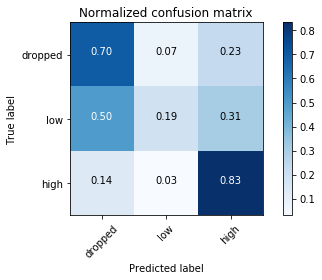

In [25]:
# Create confusion matrix
print(accuracy_score(y_test, pred_rf))

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['dropped', 'low', 'high'], normalize=True,
                      title='Normalized confusion matrix')

plt.show();

# Randomized search cross validation for hyperparameter tuning

In [28]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 600, stop = 2000, num = 8)]

# Number of features to consider at every split
max_features = ['sqrt', 'log2', 'auto']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)


# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}
pprint(random_grid)
# random search does NOT exhaust every combination; it tries a wide range of values from the grid

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['sqrt', 'log2', 'auto'],
 'n_estimators': [600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [ ]:
# Use the random grid to search for best hyperparameters
rf = RandomForestClassifier()

# Random search of parameters, using 5 fold cross validation, 80 iterations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 80, # how many iterations to try? try to use > 60. more = wider range of values tried but more time
                               cv = 5, # how many kfold for cross validation? more = reduce chance of overfitting but more time
                               verbose=2, 
                               random_state = 888, 
                               n_jobs = -1)
# Fit the random search model (using downsampled train data)
# rf_random.fit(x_train, y_train)
rf_random.fit(train_resampled.loc[:, train_resampled.columns != 'engagement_45days'], train_resampled['engagement_45days']) # resampled


In [30]:
best_random = rf_random.best_estimator_ # rf model with best parameters from random search
print(best_random)

# predict method on the test data
pred_random = best_random.predict(x_test)

# validation results
print('Validation Results')
print(rf_random.best_score_)
print('\nTest Results')
print(best_random.score(x_test, y_test))
print(recall_score(y_test, pred_random, average = None))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=40, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Validation Results
0.6111786148238153

Test Results
0.6872705018359853
[0.7  0.23 0.82]


             precision    recall  f1-score   support

    dropped       0.96      0.70      0.81      1504
        low       0.10      0.19      0.13        64
       high       0.13      0.83      0.22        66

avg / total       0.89      0.68      0.76      1634

Confusion matrix, normalized


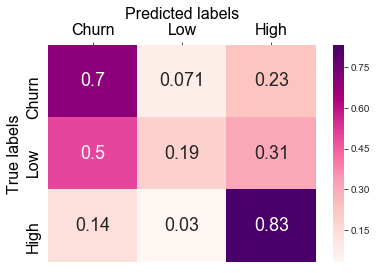

In [58]:
# classification report
colors = 'RdPu'
# colors = 'Blues'
print(classification_report(y_test, pred_rf, target_names=['dropped', 'low', 'high']))

# confusion matrix
cnf_matrix = confusion_matrix(y_test, pred_rf)

print('Confusion matrix, normalized')
ax2 = plt.subplot()
cnf_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(cnf_normalized, annot=True, fmt = '.2g', ax = ax2, cmap=colors, annot_kws={"size": 18}); #annot=True to annotate cells
# labels, title and ticks
plt.xlabel('Predicted labels', fontsize=16, color = 'black');
plt.ylabel('True labels', fontsize=16, color = 'black'); 
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position('top')
ax2.xaxis.set_ticklabels(['Churn', 'Low', 'High'], color = 'black', fontsize = 16); 
ax2.yaxis.set_ticklabels(['Churn', 'Low', 'High'], color = 'black', fontsize = 16);

# Feature importances

In [35]:
feature_importances = pd.DataFrame(best_random.feature_importances_,
                                   index = x_train.columns,
                                   columns = ['importance']).sort_values('importance', ascending=False)
feature_importances[:10]

,importance
days_in_app_2wk,0.104248
log_counts_2wk,0.100773
mean_hours_2wk,0.081047
age,0.062748
sleep_wkdy,0.042869
sleep_wknd,0.041290
show_notification_suggestion,0.014209
Q5_staying,0.013995
Q2_other,0.013885
Q3_3to4,0.013530


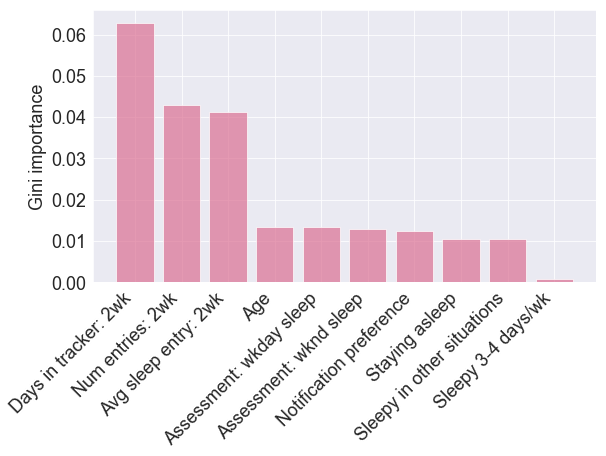

In [54]:
# plot feature importance
sns.set_style('darkgrid')
topN = 10
names = ['Days in tracker: 2wk', 'Num entries: 2wk', 'Avg sleep entry: 2wk',
        'Age', 'Assessment: wkday sleep', 'Assessment: wknd sleep', 'Notification preference', 
         'Staying asleep', 'Sleepy in other situations', 'Sleepy 3-4 days/wk']
importances = best_random.feature_importances_[:topN]

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]
indices = indices[:topN]

# Create plot
plt.figure(figsize = (9, 5))

# Add bars
p = plt.bar(range(topN), importances[indices], color = 'palevioletred', alpha = .7)

# Add feature names as x-axis labels
plt.xticks(range(topN), names, rotation = 45, ha = 'right', fontsize = 18)
plt.yticks(fontsize = 18)

plt.ylabel('Gini importance', fontsize = 18);

# ROC curves and AUC scores

In [33]:
# predict with probabilities
pred_probs = best_random.predict_proba(x_test)

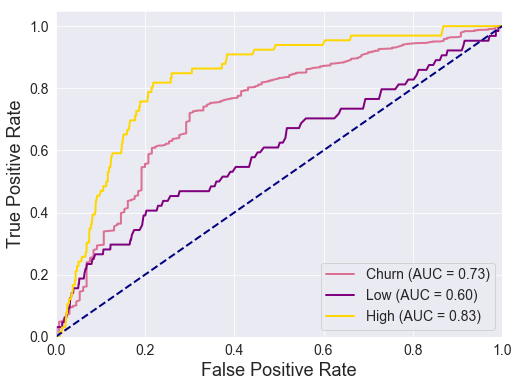

In [34]:
# ROC curves and AUC scores
fpr_churn, tpr_churn, thresholds_churn = roc_curve((y_test.values == 0).astype(int), pred_probs[:, 0].reshape(-1, 1))
score_churn = roc_auc_score((y_test.values == 0).astype(int), pred_probs[:, 0].reshape(-1, 1))
fpr_low, tpr_low, thresholds_low = roc_curve((y_test.values == 1).astype(int), pred_probs[:, 1].reshape(-1, 1))
score_low = roc_auc_score((y_test.values == 1).astype(int), pred_probs[:, 1].reshape(-1, 1))
fpr_high, tpr_high, thresholds_high = roc_curve((y_test.values == 2).astype(int), pred_probs[:, 2].reshape(-1, 1))
score_high = roc_auc_score((y_test.values == 2).astype(int), pred_probs[:, 2].reshape(-1, 1))

# plot ROC curve with AUC score
sns.set_style('darkgrid')
plt.figure(figsize = (8, 6))
lw = 2
plt.plot(fpr_churn, tpr_churn, color='palevioletred',
         lw=lw, label='Churn (AUC = %0.2f)' % score_churn)
plt.plot(fpr_low, tpr_low, color='purple',
         lw=lw, label='Low (AUC = %0.2f)' % score_low)
plt.plot(fpr_high, tpr_high, color='gold',
         lw=lw, label='High (AUC = %0.2f)' % score_high)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax = plt.gca()
ax.grid(True)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tick_params(axis='both', which='major', labelsize = 14)
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.legend(loc="lower right", prop={'size': 14})
plt.show();

# Try some other classifiers

Some other machine learning classifiers I've tried: multinomial logistic regression, naive Bayes, decision tree, k-nearest neighbors, and adaboost.

### Multinomial logistic regression

0.6340269277845777
             precision    recall  f1-score   support

    dropped       0.97      0.64      0.77      1504
        low       0.08      0.27      0.12        64
       high       0.12      0.76      0.20        66

avg / total       0.90      0.63      0.73      1634

Normalized confusion matrix
[[0.64 0.12 0.23]
 [0.34 0.27 0.39]
 [0.14 0.11 0.76]]


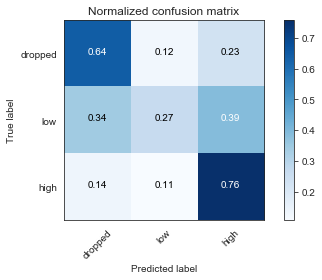

In [65]:
# fit model and make predictions
multi_lr = LogisticRegression(multi_class='multinomial',solver ='newton-cg', random_state = 888)
pred = run_model(multi_lr,
                 train_resampled.loc[:, train_resampled.columns != 'engagement_45days'], 
                 train_resampled['engagement_45days'],
                 x_test,
                 y_test)


### Naive Bayes

0.6358629130966952
             precision    recall  f1-score   support

    dropped       0.97      0.64      0.77      1504
        low       0.10      0.38      0.16        64
       high       0.12      0.74      0.21        66

avg / total       0.90      0.64      0.73      1634

Normalized confusion matrix
[[0.64 0.13 0.23]
 [0.41 0.38 0.22]
 [0.11 0.15 0.74]]


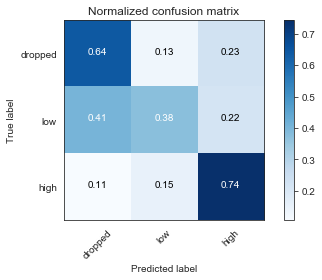

In [67]:
# fit model and make predictions
nb = MultinomialNB(class_prior=[.5, .3, .4])
pred = run_model(nb,
                 train_resampled.loc[:, train_resampled.columns != 'engagement_45days'], 
                 train_resampled['engagement_45days'],
                 x_test,
                 y_test)


### Decision tree

0.4663402692778458
             precision    recall  f1-score   support

    dropped       0.94      0.47      0.63      1504
        low       0.04      0.30      0.07        64
       high       0.08      0.48      0.13        66

avg / total       0.87      0.47      0.59      1634

Normalized confusion matrix
[[0.47 0.29 0.24]
 [0.45 0.3  0.25]
 [0.26 0.26 0.48]]


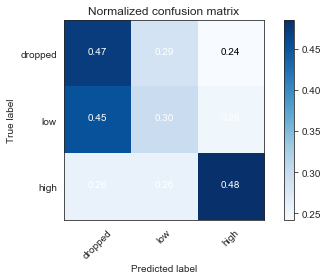

In [69]:
# fit model
dectree = DecisionTreeClassifier(random_state = 888)
pred = run_model(dectree,
                 train_resampled.loc[:, train_resampled.columns != 'engagement_45days'], 
                 train_resampled['engagement_45days'],
                 x_test,
                 y_test)


### k-Nearest Neighbors

0.6187270501835985
             precision    recall  f1-score   support

    dropped       0.95      0.64      0.76      1504
        low       0.04      0.20      0.07        64
       high       0.12      0.59      0.20        66

avg / total       0.88      0.62      0.71      1634

Normalized confusion matrix
[[0.64 0.18 0.18]
 [0.48 0.2  0.31]
 [0.29 0.12 0.59]]


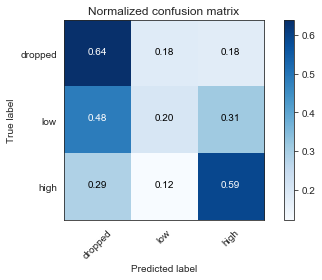

In [71]:
# fit model
knn = KNeighborsClassifier(n_neighbors = 3)
pred = run_model(knn,
                 train_resampled.loc[:, train_resampled.columns != 'engagement_45days'], 
                 train_resampled['engagement_45days'],
                 x_test,
                 y_test)


### Adaboost

0.6309669522643819
             precision    recall  f1-score   support

    dropped       0.96      0.64      0.77      1504
        low       0.08      0.30      0.12        64
       high       0.13      0.79      0.23        66

avg / total       0.89      0.63      0.72      1634

Normalized confusion matrix
[[0.64 0.15 0.21]
 [0.42 0.3  0.28]
 [0.15 0.06 0.79]]


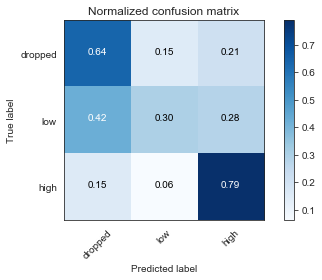

In [72]:
# fit model
adaboost = AdaBoostClassifier(random_state = 888)
pred = run_model(adaboost,
                 train_resampled.loc[:, train_resampled.columns != 'engagement_45days'], 
                 train_resampled['engagement_45days'],
                 x_test,
                 y_test)